## Utility Analysis

[Paper on using this data set for uplift modeling.](https://hal.science/hal-02515860/)

**Overview**

This file contains analysis of the utility of synthetic data sets produced using the optimized bayesian sequential synthesis and the differentially private GAN model.

A potential use case for synthetic data is to synthesize data that would otherwise be too sensitive to share, and allow companies to measure treatment efficacy conditional on those covariates.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

***

Import the original and synthesized Criteo data sets.

In [2]:
# import the confidential data
original = pd.read_csv("../../Data/Criteo/cleaned_criteo.gz", 
                       compression='gzip', 
                       sep='\,',
                       header=0,
                       engine='python')

In [3]:
original

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


***

Fit an overall model for `conversion` on the confidential data.

In [4]:
conversion_model = LogisticRegression(penalty=None)

In [5]:
X = original.drop(['conversion'], axis=1)
y = original.conversion

In [6]:
conversion_model.fit(X, y)

LogisticRegression(penalty=None)

These are the coefficients from the original model, including the intercept. We'll treat these as the 'ground truth'.

In [7]:
original_coefs = pd.Series(np.concatenate([conversion_model.intercept_, conversion_model.coef_.flatten()]))
original_coefs

0    -0.175636
1     0.012819
2    -0.709895
3    -1.012732
4    -0.063390
5     0.757181
6    -0.166353
7     0.028946
8    -0.050328
9    -0.646949
10   -0.010780
11    0.170575
12   -0.592280
13   -0.599584
14    7.431786
15    1.439664
dtype: float64

Define a function that takes a data set as input and computes the logistic regression coefficients of interest.

In [8]:
def logistic_coefs(dataset):
    # define logistic regression model
    conversion_model = LogisticRegression(penalty=None, max_iter=1000)
    # create covariates data
    X = dataset.drop(['conversion'], axis=1)
    # create outcome (target) variable
    y = dataset.conversion
    # fit model
    conversion_model.fit(X, y)
    # store coefficients
    current_coefs = pd.Series(np.concatenate([conversion_model.intercept_, conversion_model.coef_.flatten()]))
    return current_coefs

Loop over optimized synthetic data sets and compute logistic regression coefficients.

In [9]:
opt_syn_coefs = pd.DataFrame()

for i in range(20):
    # import an optimized synthetic data set
    opt_syn_temp = pd.read_csv("../../Data/Criteo/cart_" + str(i) + "_full.csv")
    opt_syn_temp = opt_syn_temp[original.columns]
    current_coefs = logistic_coefs(opt_syn_temp)
    opt_syn_coefs = pd.concat([opt_syn_coefs, current_coefs], axis=1)
    print("Coefficients for data set " + str(i) + " computed.")

Coefficients for data set 0 computed.
Coefficients for data set 1 computed.
Coefficients for data set 2 computed.
Coefficients for data set 3 computed.
Coefficients for data set 4 computed.
Coefficients for data set 5 computed.
Coefficients for data set 6 computed.
Coefficients for data set 7 computed.
Coefficients for data set 8 computed.
Coefficients for data set 9 computed.
Coefficients for data set 10 computed.
Coefficients for data set 11 computed.
Coefficients for data set 12 computed.
Coefficients for data set 13 computed.
Coefficients for data set 14 computed.
Coefficients for data set 15 computed.
Coefficients for data set 16 computed.
Coefficients for data set 17 computed.
Coefficients for data set 18 computed.
Coefficients for data set 19 computed.


In [10]:
coef_names = pd.Series(["intercept"])
coef_names = pd.concat([coef_names, pd.Series(X.columns)], axis=0)
opt_syn_coefs.index = coef_names
opt_syn_coefs.columns = np.arange(20)

Plot the distributions of regression coefficients for each method relative to the ground truth - the coefficient estimates from the original data.

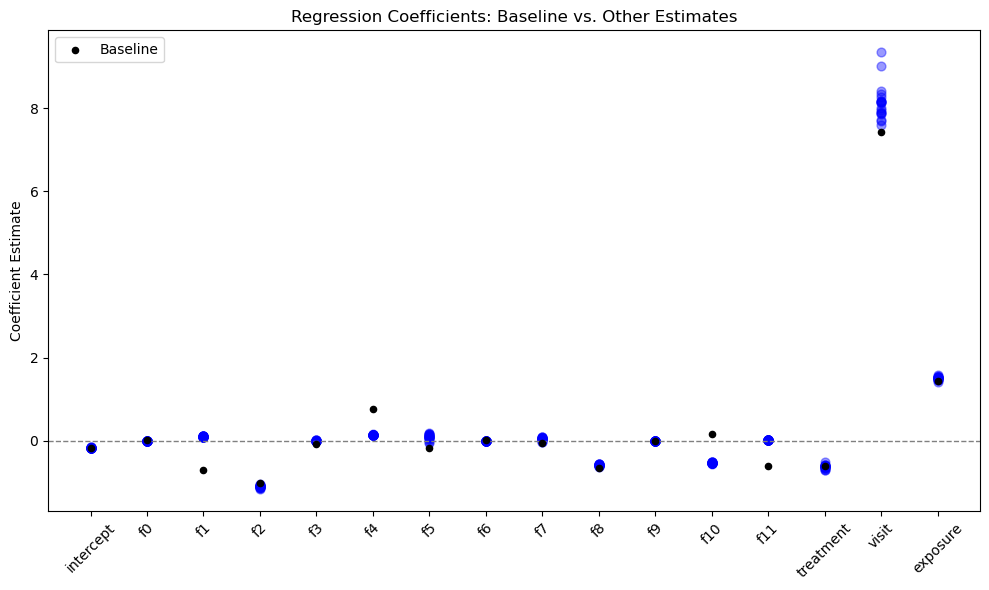

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(original_coefs))

# Baseline (black dots)
ax.scatter(x, original_coefs.values, color="black", s=20, zorder=3, label="Baseline")

# Other estimates (blue dots, semi-transparent)
for col in opt_syn_coefs.columns:
    ax.scatter(x, opt_syn_coefs[col].values, color="blue", alpha=0.4, s=40)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(opt_syn_coefs.index, rotation=45)
ax.axhline(0, color="gray", linewidth=1, linestyle="--")
ax.set_ylabel("Coefficient Estimate")
ax.legend()
ax.set_title("Regression Coefficients: Baseline vs. Other Estimates")

plt.tight_layout()
plt.show()

Fit a model on the `treatment = 0` and `treatment = 1` subsets. Compute the uplift for each observation.

Diemert et al. (2018) published a paper alongside the Criteo uplift data. They discuss a two-model approach to modeling uplift, which we utilize here for one example of a use case for synthetic data.

Tasks for Ethan:

- compute uplift for observations in the original and synthetic data sets (use the two-model approach from Diemert et al. (2020))
- compare uplift distributions from the synthetic data sets to uplift distribution from the original data using
    - Wasserstein or some other distributional distance/similarity metric
    - Mean uplift
    - std. deviation uplift
    - read up on the *area under the uplift curve* (AUUC) metric from Diemert et al. (2020). Compute the AUUC for a model trained and evaluated on the original data. Compare that to AUUC values for models trained on each synthetic data set, and evaluated on the original data.

Once this workflow is established, we can repeat it for a train/test data split. We'll train the uplift models on the original/synthetic training data, and evaluate their performance using the above metrics computed on uplift distributions from the test data.


**Note that the columns of the synthetic data sets need to be reordered after you import the data so that the order matches that of the original data**.

Real-world use cases driving these analyses?

In-sample measurements: if an advertising company or walled garden were to share the data from a past campaign, could a user obtain reasonable estimates of the uplift from the synthetic data?

Out-of-sample measurements: given the results of a previous campaign, can a model trained on the synthetic data that can give reasonably accurate estimates for uplift for *real* out-of-sample consumers?